In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage

In [61]:
np.random.seed(42)

# Load and look at data

In [62]:
train_img_dir = "/kaggle/input/airbus-ship-detection/train_v2"
train_masks_path = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
train_img_names = os.listdir(train_img_dir)

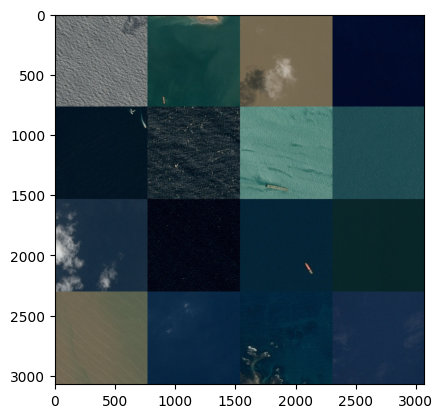

In [63]:
# look at some images
images = [imread(train_img_dir + "/" + train_img_names[i]) for i in range(16)]
plt.imshow(montage(images, channel_axis = 3))

In [64]:
# look at masks
masks = pd.read_csv(train_masks_path)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [65]:
masks["EncodedPixels"][2]

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [66]:
masks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


# function to deal with rle

In [67]:
def rle_decoder(mask_rle):
    """
    Decode a Run-Length Encoded (RLE) mask string into a binary mask array.
    If the input is not a string, a zero-filled mask array is returned.

    Parameters:
    - mask_rle (str): The RLE encoded mask string.

    Returns:
    - numpy.ndarray: Binary mask array of size IMG_SIZE 
    """
    
    if not isinstance(mask_rle, str):
        return np.zeros(IMG_SIZE)
    
    s = mask_rle.split()
    starts, lengths = (np.asarray(x, dtype=int) for x in (s[::2], s[1::2]))
    
    # Adjust start positions to be zero-based
    starts -= 1
    
    ends = starts + lengths
    
    mask = np.zeros(IMG_SIZE[0] * IMG_SIZE[1])
    assert ends[-1] <= len(mask)
    
    for start, end in zip(starts, ends):
        mask[start:end+1] = 1
    
    return mask.reshape(IMG_SIZE).T


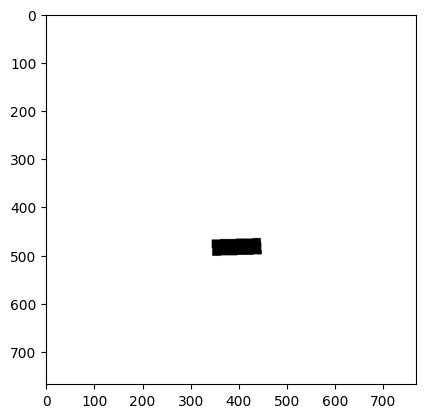

In [68]:
plt.imshow(rle_decoder(masks["EncodedPixels"][2]), cmap="gray_r")

# Count number of ships for each image

In [69]:
masks['ships'] = masks['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()

In [70]:
unique_img_ids.head()

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


<Axes: >

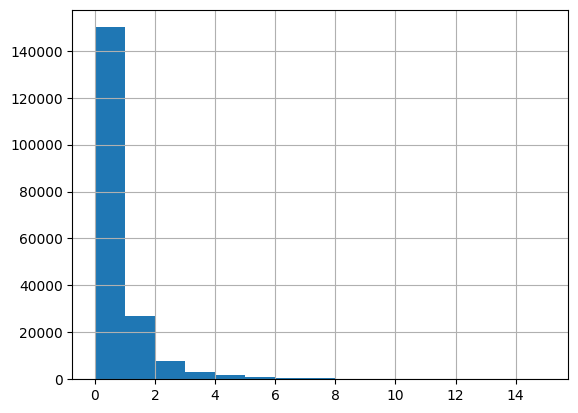

In [71]:
unique_img_ids["ships"].hist(bins=unique_img_ids["ships"].max())

# Drop part of images with no ship

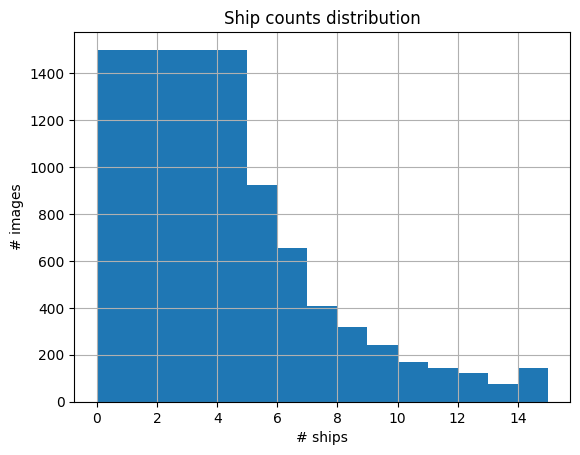

In [72]:
SAMPLES_PER_GROUP = 1500 # no bigger than 20000
balanced_ids_df = unique_img_ids.groupby("ships").apply(lambda x: x.sample(min(SAMPLES_PER_GROUP, len(x))))
balanced_ids_df["ships"].hist(bins=balanced_ids_df["ships"].max())
plt.title("Ship counts distribution")
plt.ylabel("# images")
plt.xlabel("# ships")
plt.savefig("ship count distribution")

In [73]:
# train/validation split
train_ids, val_ids = train_test_split(balanced_ids_df, test_size=0.2, stratify=balanced_ids_df["ships"])

train_df = pd.merge(masks, train_ids, how="inner", on="ImageId")
val_df = pd.merge(masks, val_ids, how="inner", on="ImageId")

In [74]:
train_df.drop(columns = ["ships_x", "ships_y"], inplace=True)
val_df.drop(columns = ["ships_x", "ships_y"], inplace=True)

print(train_df["ImageId"].nunique(), "train samples")
print(val_df["ImageId"].nunique(), "val samples")

8561 train samples
2141 val samples


# **Saving data**

In [75]:
train_df.to_csv("train_df.csv")
val_df.to_csv("val_df.csv")